In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spreg import OLS
from libpysal.weights import Kernel
from esda.moran import Moran

import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [139]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond_hourly.csv')

In [140]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)

In [4]:
# Get all green spaces
Gsp=Gsp_gdf['geometry'].unary_union

# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [5]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [6]:
# Get all near-road green spaces
nRd_Gsp=Gsp.intersection(Rd_buffer)

In [131]:
# Get all near-greenspace roads
nRd_Gsp_buffer=nRd_Gsp.buffer(50)
nGsp_Rd=Rd.intersection(nRd_Gsp_buffer)

In [8]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [134]:
# get all roads, green spaces, near-road green spaces and near-gsp roads in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
nGsp_Rd_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
    nGsp_Rd_shp.append(poly.intersection(nGsp_Rd))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp),len(nGsp_Rd_shp))

21 21 21 21


In [141]:
# append them into the dataframe
loc_gdf['Rd']=Rd_shp
loc_gdf['Gsp']=Gsp_shp
loc_gdf['nRd_Gsp']=nRd_Gsp_shp
loc_gdf['nGsp_Rd']=nGsp_Rd_shp

# and set their data types to geometry
loc_gdf=loc_gdf.set_geometry('Rd').set_geometry('Gsp').set_geometry('nRd_Gsp').set_geometry('nGsp_Rd')

In [11]:
# london boundary read in
london=gpd.read_file('data/london_boundary.shp')

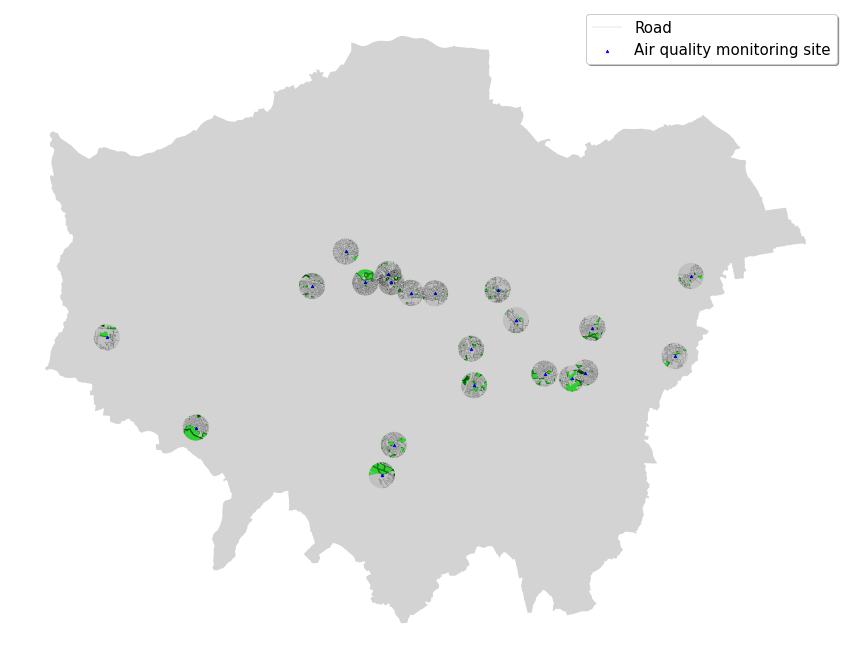

In [12]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['Gsp'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['nRd_Gsp'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Rd'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [142]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [143]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Rd,Gsp,nRd_Gsp,nGsp_Rd,min_dis
siteid,,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",MULTILINESTRING Z ((530466.022 181148.842 0.00...,664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",MULTILINESTRING Z ((530105.671 181827.567 0.00...,664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",MULTILINESTRING Z ((545144.788 174118.625 0.00...,1111.316933


In [15]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.869803   9.945936  0.1  4.9   7.9  12.425  92.4
CD9   8760.0  13.753847  10.294305  0.1  7.4  11.1  16.300  83.9
GB0   8760.0  12.177603   8.968893  0.1  6.8   9.5  14.000  79.8
GR4   8760.0  11.002225   9.712762  0.1  5.4   8.3  12.300  97.6

In [16]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-64.50762336133032, pvalue=0.0)

In [17]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-23.998842951363066, pvalue=2.5707190294625883e-123)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [144]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [145]:
loc_gdf['Rd_len']=loc_gdf['Rd'].length

In [146]:
# get percentages of green space and near-road green space areas 
loc_gdf['pct_Gsp']=loc_gdf['Gsp'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nRd_Gsp']=loc_gdf['nRd_Gsp'].area/loc_gdf['Gsp'].area # percentage of near road gsp area

In [147]:
loc_gdf['nRd_Gsp_per_Rd_len']=loc_gdf['nRd_Gsp'].area/loc_gdf['Rd_len']

In [148]:
loc_gdf['pct_nGsp_Rd']=loc_gdf['nGsp_Rd'].length/loc_gdf['Rd_len']

In [149]:
loc_gdf[['nGsp_Rd','pct_nGsp_Rd']]

,nGsp_Rd,pct_nGsp_Rd
siteid,,
BX9,MULTILINESTRING Z ((551296.805 175551.798 0.00...,0.122449
BL0,MULTILINESTRING Z ((530466.022 181148.842 0.00...,0.213543
CD9,MULTILINESTRING Z ((530105.671 181827.567 0.00...,0.266694
CD1,MULTILINESTRING Z ((527312.660 183662.749 0.00...,0.093167
CT2,MULTILINESTRING Z ((531654.842 180233.314 0.00...,0.153286
CT3,MULTILINESTRING Z ((534069.653 180380.464 0.00...,0.160035
CR8,MULTILINESTRING Z ((530068.000 168619.000 0.00...,0.167062
GR4,MULTILINESTRING Z ((544415.352 173756.882 0.00...,0.320092
GB0,MULTILINESTRING Z ((545144.788 174118.625 0.00...,0.172209


In [150]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Site                183960 non-null  object  
 1   Value               183960 non-null  float64 
 2   DateTime            183960 non-null  object  
 3   sitename            183960 non-null  object  
 4   geometry            183960 non-null  geometry
 5   buffer_1km          183960 non-null  geometry
 6   Rd                  183960 non-null  geometry
 7   Gsp                 183960 non-null  geometry
 8   nRd_Gsp             183960 non-null  geometry
 9   nGsp_Rd             183960 non-null  geometry
 10  min_dis             183960 non-null  float64 
 11  buffer_area         183960 non-null  float64 
 12  Rd_len              183960 non-null  float64 
 13  pct_Gsp             183960 non-null  float64 
 14  pct_nRd_Gsp         183960 non-null  float64 
 15  nRd_Gsp_per_Rd_le

In [151]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Rd','Gsp','nRd_Gsp','nGsp_Rd','min_dis','buffer_area'],
        axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Site                183960 non-null  object  
 1   Value               183960 non-null  float64 
 2   DateTime            183960 non-null  object  
 3   geometry            183960 non-null  geometry
 4   Rd_len              183960 non-null  float64 
 5   pct_Gsp             183960 non-null  float64 
 6   pct_nRd_Gsp         183960 non-null  float64 
 7   nRd_Gsp_per_Rd_len  183960 non-null  float64 
 8   pct_nGsp_Rd         183960 non-null  float64 
dtypes: float64(6), geometry(1), object(2)
memory usage: 14.0+ MB


In [53]:
# kernel weight matrix for the sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [33]:
# moran's Is for PM readings on different days
moran=[]
for date in df['DateTime'].unique():
    mi=Moran(df[df['DateTime']==date].Value.values,weight)
    moran.append(mi.I)
len(moran)

8760

In [63]:
var_names=loc_gdf.columns[9:].values

In [69]:
for var in var_names:
    moran_temp=Moran(loc_gdf[var].values,weight)
    print("Global Moran's I for "+var+' '+str(round(moran_temp.I,5)))

Global Moran's I for Rd_len 0.23493
Global Moran's I for pct_Gsp 0.15159
Global Moran's I for pct_nRd_Gsp 0.11296
Global Moran's I for nRd_Gsp_per_Rd_len 0.131
Global Moran's I for pct_nGsp_Rd 0.19495


In [152]:
# covert the DateTime column to numpy.datetime variable
df['DateTime']=pd.to_datetime(df['DateTime'])

<AxesSubplot:>

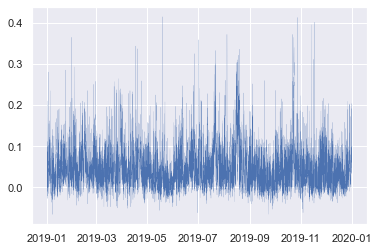

In [72]:
# change of moran's I during the year of 2019
sns.set_theme(style='darkgrid')
sns.lineplot(x=df['DateTime'].unique(),y=moran,linewidth=0.13)

In [153]:
# merge with conditional variables
cond['DateTime']=pd.to_datetime(cond['DateTime'])
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Site                183960 non-null  object        
 1   Value               183960 non-null  float64       
 2   DateTime            183960 non-null  datetime64[ns]
 3   geometry            183960 non-null  geometry      
 4   Rd_len              183960 non-null  float64       
 5   pct_Gsp             183960 non-null  float64       
 6   pct_nRd_Gsp         183960 non-null  float64       
 7   nRd_Gsp_per_Rd_len  183960 non-null  float64       
 8   pct_nGsp_Rd         183960 non-null  float64       
 9   bp_mean             183960 non-null  float64       
 10  tmp_mean            183960 non-null  float64       
 11  rh_mean             183960 non-null  float64       
dtypes: datetime64[ns](1), float64(9), geometry(1), object(1)
memory usage: 18.2+ MB


array([[<AxesSubplot:title={'center':'Value'}>,
        <AxesSubplot:title={'center':'DateTime'}>,
        <AxesSubplot:title={'center':'Rd_len'}>],
       [<AxesSubplot:title={'center':'pct_Gsp'}>,
        <AxesSubplot:title={'center':'pct_nRd_Gsp'}>,
        <AxesSubplot:title={'center':'nRd_Gsp_per_Rd_len'}>],
       [<AxesSubplot:title={'center':'pct_nGsp_Rd'}>,
        <AxesSubplot:title={'center':'bp_mean'}>,
        <AxesSubplot:title={'center':'tmp_mean'}>],
       [<AxesSubplot:title={'center':'rh_mean'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

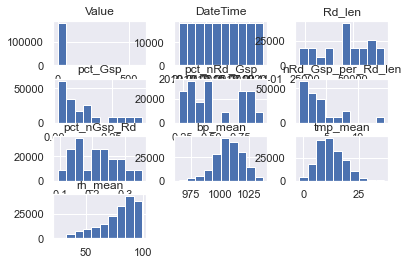

In [154]:
df.hist()

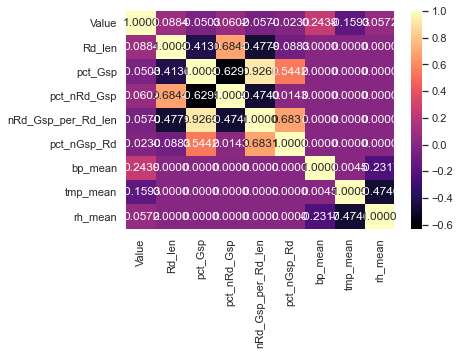

In [155]:
sns.heatmap(df.corr(method='spearman').round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [156]:
df['week']=df['DateTime'].dt.isocalendar().week

<AxesSubplot:xlabel='hour'>

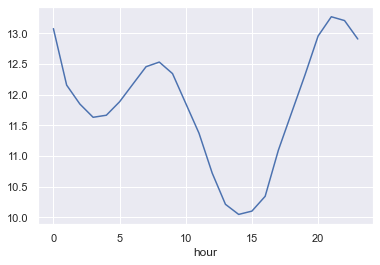

In [157]:
df['hour']=df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

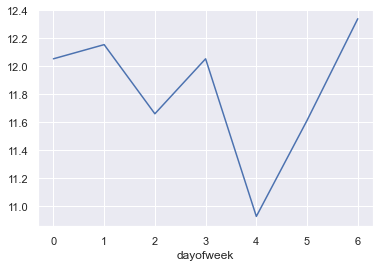

In [158]:
df['dayofweek']=df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

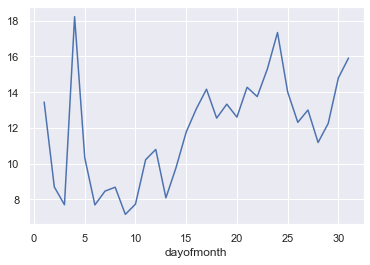

In [159]:
df['dayofmonth']=df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [160]:
hmean_df=df.groupby(['hour','Site']).mean()
hmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Value               504 non-null    float64
 1   Rd_len              504 non-null    float64
 2   pct_Gsp             504 non-null    float64
 3   pct_nRd_Gsp         504 non-null    float64
 4   nRd_Gsp_per_Rd_len  504 non-null    float64
 5   pct_nGsp_Rd         504 non-null    float64
 6   bp_mean             504 non-null    float64
 7   tmp_mean            504 non-null    float64
 8   rh_mean             504 non-null    float64
 9   week                504 non-null    Float64
 10  dayofweek           504 non-null    float64
 11  dayofmonth          504 non-null    float64
dtypes: Float64(1), float64(11)
memory usage: 49.2+ KB


In [161]:
hmean_df.head()

Value        Rd_len   pct_Gsp  pct_nRd_Gsp  nRd_Gsp_per_Rd_len  \
hour Site                                                                       
0    BL0   11.430771  66247.190928  0.052078     0.817371            2.015396   
     BX9   12.952238  36565.805888  0.062358     0.363473            1.944190   
     CD1   11.153831  51527.369854  0.035043     0.352480            0.751874   
     CD9   13.236543  60641.160028  0.052833     0.804692            2.198958   
     CR8   12.142372  47234.530733  0.127605     0.302947            2.567005   

           pct_nGsp_Rd      bp_mean   tmp_mean    rh_mean       week  \
hour Site                                                              
0    BL0      0.213543  1007.938404  10.047669  87.513372  26.430137   
     BX9      0.122449  1007.938404  10.047669  87.513372  26.430137   
     CD1      0.093167  1007.938404  10.047669  87.513372  26.430137   
     CD9      0.266694  1007.938404  10.047669  87.513372  26.430137   
     CR8      0.167062  1007.938404  10.047669  87.513372  26.430137   

           dayofweek  dayofmonth  
hour Site                         
0    BL0    2.994521   15.720548  
     BX9    2.994521   15.720548  
     CD1    2.994521   15.720548  
     CD9    2.994521   15.720548  
     CR8    2.994521   15.720548

In [162]:
hmean_df.drop(['week','dayofweek','dayofmonth'],axis=1,inplace=True)

In [163]:
hmean_corr=[]
hmean_reg_score=[]
reg=LinearRegression()

for index in range(24):
    hmean_corr.append(hmean_df.loc[(index,)].corr(method='spearman').loc[var_names,'Value'])
    x=hmean_df.loc[(index,),var_names].values
    y=hmean_df.loc[(index,),'Value'].values
    reg.fit(x,y)
    hmean_reg_score.append(reg.score(x,y))
hmean_corr=np.asarray(hmean_corr)
print(hmean_corr.shape,len(hmean_reg_score))

(24, 5) 24


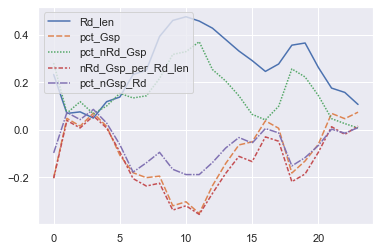

In [164]:
# this is the one uses spearman
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

<AxesSubplot:>

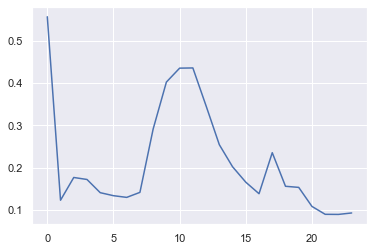

In [165]:
sns.lineplot(x=range(24),y=hmean_reg_score)

In [166]:
h_corr=[]
h_reg_score=[]
for h in range(24):
    h_corr.append(df[df['hour']==h].corr(method='spearman').loc[var_names,'Value'])
    x=df[df['hour']==h].loc[:,var_names].values
    y=df[df['hour']==h].loc[:,'Value'].values
    reg.fit(x,y)
    h_reg_score.append(reg.score(x,y))
h_corr=np.asarray(h_corr)
print(h_corr.shape,len(h_reg_score))

(24, 5) 24


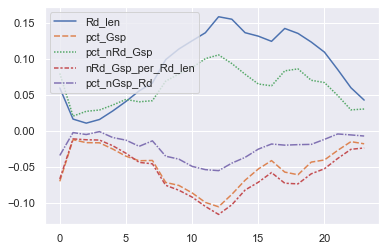

In [167]:
# this is the one uses spearman
sns.lineplot(data=h_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

<AxesSubplot:>

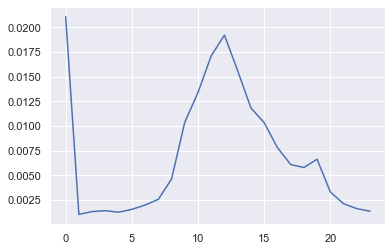

In [168]:
sns.lineplot(x=range(24),y=h_reg_score)

<AxesSubplot:xlabel='month'>

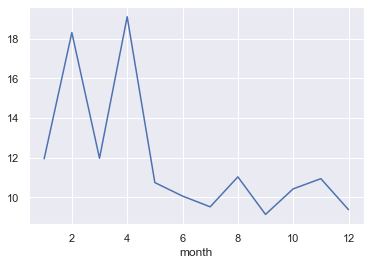

In [169]:
# set up a new column for month information
df['month']=df['DateTime'].dt.month

# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [170]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Value               252 non-null    float64
 1   Rd_len              252 non-null    float64
 2   pct_Gsp             252 non-null    float64
 3   pct_nRd_Gsp         252 non-null    float64
 4   nRd_Gsp_per_Rd_len  252 non-null    float64
 5   pct_nGsp_Rd         252 non-null    float64
 6   bp_mean             252 non-null    float64
 7   tmp_mean            252 non-null    float64
 8   rh_mean             252 non-null    float64
 9   week                252 non-null    Float64
 10  hour                252 non-null    float64
 11  dayofweek           252 non-null    float64
 12  dayofmonth          252 non-null    float64
dtypes: Float64(1), float64(12)
memory usage: 26.7+ KB


In [171]:
mmean_corr=[]
mmean_reg_score=[]

for month in range(1,13):
    mmean_corr.append(mmean_df.loc[(month,)].corr(method='spearman').loc[var_names,'Value'])
    x=mmean_df.loc[(month,)].loc[:,var_names].values
    y=mmean_df.loc[(month,)].loc[:,'Value'].values
    reg.fit(x,y)
    mmean_reg_score.append(reg.score(x,y))
mmean_corr=np.asarray(mmean_corr)
print(mmean_corr.shape,len(mmean_reg_score))

(12, 5) 12


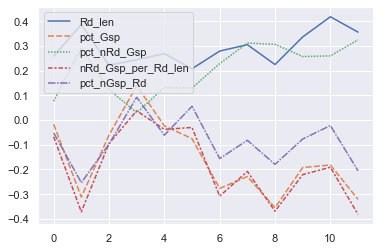

In [172]:
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

<AxesSubplot:>

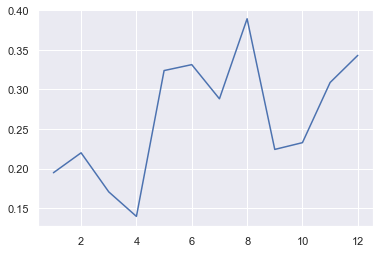

In [173]:
sns.lineplot(x=range(1,13),y=mmean_reg_score)

In [174]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].copy()
low=df[~df['month'].isin([1,2,3,4])].copy()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (60480, 17)
low: (123480, 17)


In [175]:
high.groupby('Site').mean().corr()

,Value,Rd_len,pct_Gsp,pct_nRd_Gsp,nRd_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,week,hour,dayofweek,dayofmonth,month
Value,1.000000,0.360106,-0.047135,0.152601,-0.127392,-0.096121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rd_len,0.360106,1.000000,-0.440939,0.692594,-0.562349,-0.182350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_Gsp,-0.047135,-0.440939,1.000000,-0.631936,0.880074,0.559981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_nRd_Gsp,0.152601,0.692594,-0.631936,1.000000,-0.474914,0.062499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nRd_Gsp_per_Rd_len,-0.127392,-0.562349,0.880074,-0.474914,1.000000,0.730057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_nGsp_Rd,-0.096121,-0.182350,0.559981,0.062499,0.730057,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bp_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmp_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rh_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
y_high=(high.groupby('Site').mean()['Value'].values)
x_high=(high.groupby('Site').mean()[var_names].values)

reg.fit(x_high,y_high)
reg.score(x_high,y_high)

0.16472916011217498

In [177]:
log_y_high=np.log(high.groupby('Site').mean()['Value'].values)
log_x_high=np.log(high.groupby('Site').mean()[var_names].values)

reg.fit(log_x_high,log_y_high)
reg.score(log_x_high,log_y_high)

-0.5035710105251123

In [178]:
low.groupby('Site').mean().corr()

,Value,Rd_len,pct_Gsp,pct_nRd_Gsp,nRd_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,week,hour,dayofweek,dayofmonth,month
Value,1.000000,0.315295,-0.111358,0.368525,-0.127065,-0.079047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rd_len,0.315295,1.000000,-0.440939,0.692594,-0.562349,-0.182350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_Gsp,-0.111358,-0.440939,1.000000,-0.631936,0.880074,0.559981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_nRd_Gsp,0.368525,0.692594,-0.631936,1.000000,-0.474914,0.062499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nRd_Gsp_per_Rd_len,-0.127065,-0.562349,0.880074,-0.474914,1.000000,0.730057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_nGsp_Rd,-0.079047,-0.182350,0.559981,0.062499,0.730057,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bp_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmp_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rh_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
y_low=(low.groupby('Site').mean()['Value'].values)
x_low=(low.groupby('Site').mean()[var_names].values)

reg.fit(x_low,y_low)
reg.score(x_low,y_low)

0.297626855413719